In [1]:
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
from dally.src.trainers.cifar10_trainer import Trainer
from omegaconf import OmegaConf
from dally.src.sampler import Sampler
import torch
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

--------------------------------------------------------------------------
detected:

  Local host:            ultramar
  Device name:           mlx5_2
  Device vendor ID:      0x02c9
  Device vendor part ID: 4123

Default device parameters will be used, which may result in lower
performance.  You can edit any of the files specified by the
btl_openib_device_param_files MCA parameter to set values for your
device.

NOTE: You can turn off this warning by setting the MCA parameter
      btl_openib_warn_no_device_params_found to 0.
--------------------------------------------------------------------------
--------------------------------------------------------------------------

  Local host:   ultramar
  Local device: mlx5_2
--------------------------------------------------------------------------


In [4]:
trainer = Trainer(OmegaConf.load("configs/cifar10.yaml"))

{'self': UNetModel(), 'image_size': 32, 'in_channels': 3, 'model_channels': 128, 'out_channels': 3, 'num_res_blocks': 3, 'attention_resolutions': [2, 4], 'dropout': 0.3, 'channel_mult': [1, 2, 2, 2], 'conv_resample': True, 'dims': 2, 'use_checkpoint': False, 'num_heads': 4, 'num_head_channels': -1, 'num_heads_upsample': -1, 'use_scale_shift_norm': True, 'resblock_updown': True, 'use_new_attention_order': False, 'num_classes': 10, 'learned_sinusoidal_pos_emb': False, 'cond_on_text': False, 'cond_on_vec': False, 'cond_on_discrete': True, 'lowres_time_cond': False, 'dim_text': None, 'dim_vec': None, 'attn_pool_depth': 2, 'attn_pool_dim_head': 64, 'attn_pool_heads': -1, 'attn_pool_num_latents': 64, 'num_time_tokens': 4, 'max_seq_len': 128, '__class__': <class 'dally.src.guided_diffusion.unet.UNetModel'>}


09/21/2022 14:32:37 - INFO - dally.src.trainers.cifar10_trainer -   TOTAL PARAMS: 57358979
09/21/2022 14:32:38 - INFO - dally.src.trainers.cifar10_trainer -   Building optimizers.
09/21/2022 14:32:38 - INFO - dally.src.trainers.cifar10_trainer -   Total model file chunks: None
09/21/2022 14:32:38 - INFO - dally.src.trainers.cifar10_trainer -   Could not load checkpoint on 0
09/21/2022 14:32:38 - INFO - dally.src.trainers.cifar10_trainer -   Building train dataset.


In [5]:
trainer._set_dirs_and_resume(ckpt_path="cifar/ckpt_000045000.pth")

09/21/2022 14:32:39 - INFO - dally.src.trainers.cifar10_trainer -   Total model file chunks: 1


In [7]:
trainer.emas[-1].ema_model.eval();

In [84]:
sampler = Sampler(unet=trainer.emas[-1].ema_model, noise_scheduler=trainer._ddpm.noise_scheduler, clamp=False)

In [185]:
# frog class
labels = 6 * torch.ones(1, dtype=torch.long).cuda()

In [186]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize

In [229]:
dataset = CIFAR10(
    root='./cache/', 
    train=True, 
    download=True, transform=Compose([ToTensor(), Normalize(0.5, 0.5, 0.5)])
)

Files already downloaded and verified


In [188]:
img = dataset[4][0].unsqueeze(0).cuda()
labels = dataset[4][1] * torch.ones(1, dtype=torch.long).cuda()

In [190]:
z_true = sampler.heun_solve((1, 3, 32, 32), num_timesteps=200, labels=labels, noise=img, progress=True, ode_steps=6, reverse_flow=True)

sampling loop time step: 100%|██████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.62it/s]


In [90]:
img_recon = sampler.heun_solve((1, 3, 32, 32), num_timesteps=200, labels=labels, noise=z, progress=True, ode_steps=6, reverse_flow=False)

sampling loop time step: 100%|██████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.72it/s]


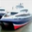

In [92]:
ToPILImage()(img_recon[0].add(1).div(2).clamp(0, 1))

# log likelihood computation

In [93]:
from scipy.integrate import solve_ivp
import numpy as np

In [94]:
sampler2 = Sampler(unet=trainer.emas[-1].ema_model, noise_scheduler=trainer._ddpm.noise_scheduler, clamp=True)

In [136]:
def rhs_for_ll(t, x, labels=None):
    # switch time order for scipy (1->0 => 0->1)
    t = 1 - t 
    t = torch.FloatTensor([t]).cuda()
    
    
    N = x.shape[0]
    # x = (x, jac)
    
    x = x[:-1]
    
    x = torch.FloatTensor(x.reshape(1, 3, 32, 32)).cuda().requires_grad_(True)
    
    eps = torch.randn_like(x)
    
    ode_rhs = sampler2.ode_rhs(x, t, labels=labels)
    hutch = (ode_rhs * eps).sum()
    jac = (torch.autograd.grad([hutch], [x])[0] * eps).sum()
    return np.concatenate([ode_rhs.detach().cpu().numpy().reshape(-1), [jac.item()]])
       

In [137]:
labels = torch.LongTensor([3]).cuda()

In [218]:
img = dataset[4][0].unsqueeze(0).cuda()
labels = dataset[3][1] * torch.ones(1, dtype=torch.long).cuda()

In [168]:
z = np.random.randn(3 * 32 * 32)

In [202]:
z = z_true.cpu().numpy().reshape(-1)

In [203]:
import torch.distributions as D

In [204]:
normal = D.Normal(0, 1)

In [205]:
log_prob = normal.log_prob(torch.from_numpy(z)).sum().item()

In [206]:
iv = np.concatenate([z, [log_prob]])

In [219]:
sol = solve_ivp(lambda t, y: rhs_for_ll(t, y, labels=labels), [1e-5, 1-1e-5], y0=iv, rtol=1e-5, atol=1e-5)

In [220]:
img_sample = torch.from_numpy(sol.y[:, -1][:3072].reshape(3, 32, 32))

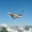

In [221]:
ToPILImage()(img_sample.add(1).div(2).clamp(0, 1))

In [215]:
labels

tensor([6], device='cuda:0')

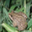

In [217]:
ToPILImage()(img[0].add(1).div(2).clamp(0, 1))

In [222]:
sol.y[:, -1][-1] / 3072

-5.657707730300313

In [ ]:
# try to classify:

In [223]:
from tqdm import tqdm

In [230]:
img = dataset[0][0].unsqueeze(0).cuda()
ll = []
for label in tqdm(range(10)):
    labels = label * torch.ones(1, dtype=torch.long).cuda()
    
    z = sampler.heun_solve((1, 3, 32, 32), num_timesteps=200, labels=labels, noise=img, progress=True, ode_steps=6, reverse_flow=True)
    z = z.cpu().numpy().reshape(-1)
    log_prob = normal.log_prob(torch.from_numpy(z)).sum().item()
    iv = np.concatenate([z, [log_prob]])
    sol = solve_ivp(lambda t, y: rhs_for_ll(t, y, labels=labels), [1e-5, 1-1e-5], y0=iv, rtol=1e-5, atol=1e-5)
    ll.append(sol.y[:, -1][-1] / 3072)

sampling loop time step:   2%|█▊                                                                                      | 4/200 [00:00<00:16, 11.70it/s]


sampling loop time step:   6%|█████▏                                                                                 | 12/200 [00:01<00:15, 12.01it/s]


sampling loop time step:  10%|████████▋                                                                              | 20/200 [00:01<00:15, 12.00it/s]


sampling loop time step:  14%|███████████▋                                                                           | 27/200 [00:02<00:15, 11.48it/s]


sampling loop time step:  18%|███████████████▋                                                                       | 36/200 [00:03<00:13, 11.83it/s]


sampling loop time step:  22%|██████████████████▋                                                                    | 43/200 [00:03<00:13, 11.86it/s]


sampling loop time step:  26%|██████████████████████▌                                                                | 52/200 [00:04<00:12, 12.29it/s]


sampling loop time step:  30%|██████████████████████████                                                             | 60/200 [00:05<00:12, 11.67it/s]


sampling loop time step:  34%|█████████████████████████████▌                                                         | 68/200 [00:05<00:10, 12.21it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:06<00:00, 30.69s/it]


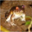

In [235]:
ToPILImage()(img[0].add(1).div(2).clamp(0, 1))

In [236]:
img_sample = torch.from_numpy(sol.y[:, -1][:3072].reshape(3, 32, 32))

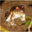

In [237]:
ToPILImage()(img_sample.add(1).div(2).clamp(0, 1))

In [238]:
label

9

In [239]:
ll

[-4.796724252740798,
 -4.78117864906299,
 -4.826462013083072,
 -4.789173935372249,
 -4.810514154516479,
 -4.77295617556767,
 -4.8182927547211944,
 -4.813261324029355,
 -4.801839396375461,
 -4.815933030265042]